# Encoders: Categorical input and Categorical output Example
The prevous examples all used binary output, hence used BinaryCrossEntropy loss. It can be thought of as a __multi label, binary-class__ problem.

From a loss perspective we can also turn this into a __multi-label, multi-class__ problem, where we see each categorical field as a different label to predict. And then use regular CrossEntropy (LogMax + Negative-Log-Likelihood) over all the labels. Intuitively we might assume this might have an equalizing effect on the loss. The loss might be less dependent on the cardinality of the feature.

Image classification is a typical multi-class problem where the networks gets an image and returns the class it thinks the image is, for instance 1 for a person, 2 for a car, 3 for a plane etc... So here we are sort of doing a multi image classifier, with multiple images (our categorical feature).

----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object

In [3]:
# Change this to read from another location
file = '../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])


age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_binned,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(learning_features, df, inference=False)

df

2020-11-13 15:01:23.550 d373c7.engines.common          INFO     Start Engine...
2020-11-13 15:01:23.551 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-13 15:01:23.551 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-13 15:01:23.551 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../data/bs140513_032310.csv
2020-11-13 15:01:23.755 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-11-13 15:01:23.761 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 6)
2020-11-13 15:01:23.761 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <False>
2020-11-13 15:01:23.806 d373c7.engines.panda_numpy     INFO     Done creating learning. Shape=(594643, 6)


,age_index,gender_index,merchant_index,category_index,amount_bin,fraud_label
0,1,1,1,1,1,0
1,2,1,1,1,1,0
2,1,2,2,1,1,0
3,3,1,1,1,1,0
4,4,1,1,1,1,0
...,...,...,...,...,...,...
594638,3,2,2,1,1,0
594639,1,2,2,1,1,0
594640,2,2,15,11,1,0
594641,4,1,2,1,1,0


## Convert to Numpy

In [5]:
with en.EnginePandasNumpy() as e:
    data_list = e.to_numpy_list(learning_features, df)
print(data_list.shapes)
print(data_list.dtype_names)

2020-11-13 15:01:26.814 d373c7.engines.common          INFO     Start Engine...
2020-11-13 15:01:26.814 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-13 15:01:26.815 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-13 15:01:26.815 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int16
2020-11-13 15:01:26.815 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Categorical
2020-11-13 15:01:26.820 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-11-13 15:01:26.821 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 5), (594643,)]
['int16', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__. For auto-encoders we perform a 4th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 4. Remove fraud from training and validation

In [6]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(learning_features, 0)
val_data = val_data.filter_label(learning_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(458847, 5), (458847,)]
Validation Data shapes [(29670, 5), (29670,)]
Test Data shapes [(100000, 5), (100000,)]
Done


## Set up Devices

In [7]:
device, cpu = pt.init_devices()

2020-11-13 15:01:31.115 d373c7.pytorch.common          INFO     Torch Version : 1.6.0
2020-11-13 15:01:31.164 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-11-13 15:01:31.165 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


## Define model

> Define a __CategoricalToCategoricalAutoEncoder__. As input it takes the size of the latent dimension. In this case *3*. And it takes a list of integers indicating the number and the size of the hidden dimensions. *We are defining it to have 1 hidden layer of size 16*.

> As first layer this encoder now uses embeddings. Each categorical feature has its own embedding like in the classification examples. 

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, shuffle=True)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a model
m = pm.CategoricalToCategoricalAutoEncoder(learning_features, latent_dim=3, layers=[16])
print(m)

CategoricalToCategoricalAutoEncoder(
  Number of parameters : 7254
  (encoder): LatentLinearEncoder(
    Number of parameters : 2855
    (head): TensorDefinitionHead(
      lcs=['Categorical']
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(9, 4)
          (1): Embedding(5, 4)
          (2): Embedding(51, 25)
          (3): Embedding(16, 7)
          (4): Embedding(31, 15)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (linear): LinDropAct(
      (layers): Sequential(
        (0): Linear(in_features=55, out_features=16, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU(inplace=True)
      )
    )
    (latent): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): LatentLinearDecoder(
    (linear): LinDropAct(
      (layers): Sequential(
        (0): Linear(in_features=3, out_features=16, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU(inplace=True)
      )
 

Graphically this model more or less looks like below

> Much like the previous example we compress to 3 latent features in the encoder

> The latent feature are decoded to 16 layers. But then rather than converting this into a single 112 size rank 1 tensor, we now make it a 5 by 51 rank __2__ tensor. So its effectively and array rather than a vector. This tensor contains the logits score. So one score per class per label. The columns corresponds to the number of classes we predict (We took the maximum over the input features + 1, so 51). The row corresponds to the number of labels we predict (i.e. the number of categorical feature). We *LogSoftMax* over the columns and *NNL-Loss* over the rows to calculate the __CrossEntropyLoss__

> This ouput layer has a lot of parameters. That impacts the 'capacity' of the model. This model has considerably more parameters as compared to the previous models due to this bigger output layer.

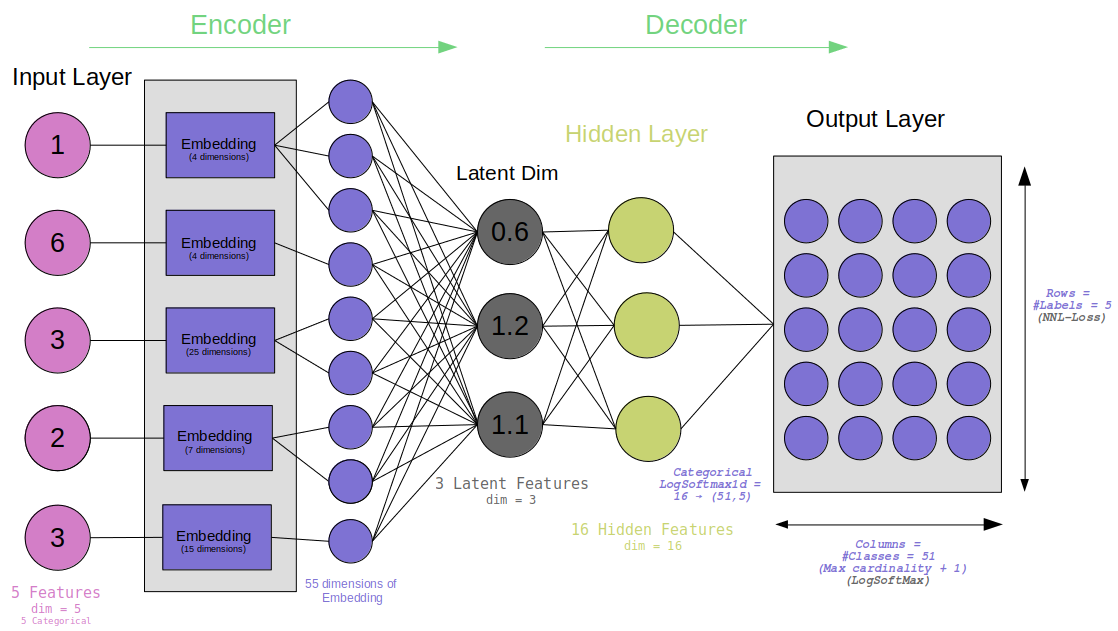

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. 

2020-11-13 15:01:35.248 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 324.08it/s]
2020-11-13 15:01:37.415 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


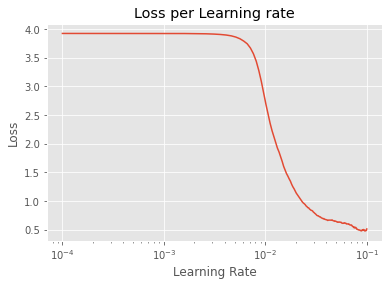

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __8 epochs__ and __learning rate 3e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate.

Epoch 005/005: 100%|██████████| 3817/3817 [00:09<00:00, 404.64it/s, train_loss=0.0877, val_loss=0.0378]


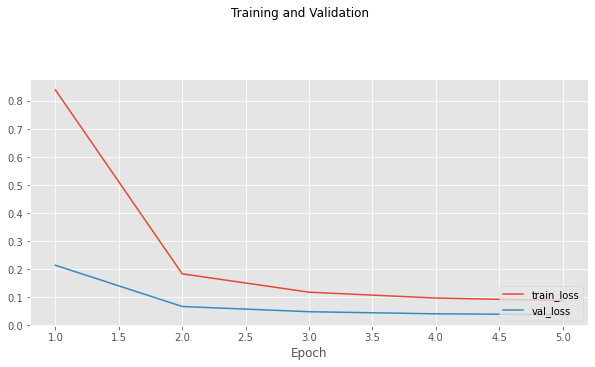

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 3e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 956.32it/s]


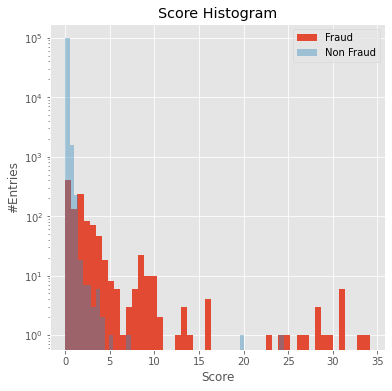

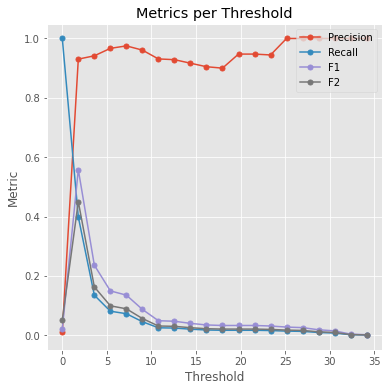

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.84      0.59      0.69      1074

    accuracy                           0.99    100000
   macro avg       0.92      0.79      0.85    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9757
ap score  : 0.6707
-----------------------------------------------------


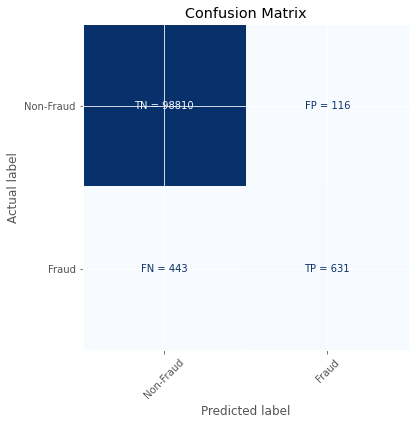

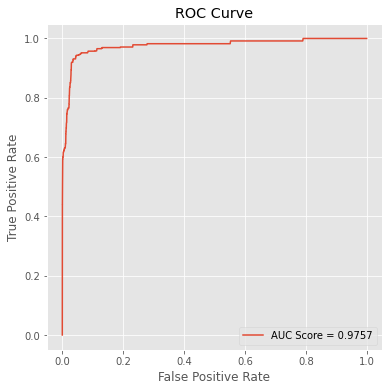

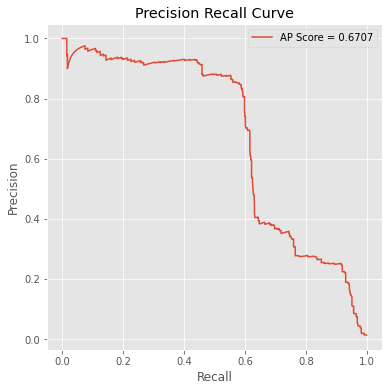

In [16]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=1.20)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=1.20)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

## Plot Embeddings
> Because we now created an embedding (Like in one of the classifier examples) we can visualize it. The plot_embedding method will take the `FeatureIndex` named __category_i__, PCA it and display the 3 principal components. 

> It should be clear that this embedding is much different that the classifier example. The *es_leisure* us not longer a massive outlier and the first component no longer accounts for a incredible amount of variance. That should not be a surprise, the task we are trying to solve here is very different.

> It is also different from the embedding if we use Binary Output. There is more variation in the first component. As mentioned earlier this is the better guess work, but there is a chance this is due to the fact there is more balance in the way the feature contribute to the loss. (It should depend less on their cardinality)

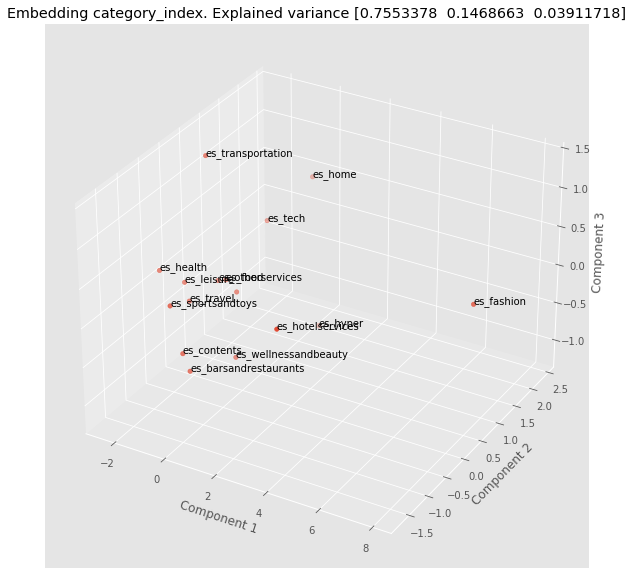

In [15]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))